# Mini-Lab: Logistic Regression and SVMs

*Contributors*: Balaji Avvaru, Joshua Eysenbach, Vijay Kaniti, Daniel Turner

Nbviewer link: https://nbviewer.jupyter.org/github/balajiavvaru/MSDS_7331/blob/master/Code/Minilab_Group_3.ipynb

In this mini-lab, we will build classification models for a positive or negative cardiovascular disease diagnosis (the target variable *cardio*) using both logistic regression and support vector machines. 

## Create Models

#### Data Import and Attribute Adjustments

After pre-processing the cardiovascular dataset from Lab 1, a new file has been created and uploaded to Github with all of the changes made so far.

In [1]:
import pandas as pd
import numpy as np
from pandas_profiling import ProfileReport
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay
from plot_metric.functions import BinaryClassification
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

df = pd.read_csv("https://raw.githubusercontent.com/jteysen/MSDS-7331-Machine-Learning-I/master/Code/Lab2/CVD.csv")
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68523 entries, 0 to 68522
Data columns (total 14 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   gender         68523 non-null  int64  
 1   height         68523 non-null  int64  
 2   weight         68523 non-null  float64
 3   ap_hi          68523 non-null  int64  
 4   ap_lo          68523 non-null  int64  
 5   cholesterol    68523 non-null  int64  
 6   gluc           68523 non-null  int64  
 7   smoke          68523 non-null  int64  
 8   alco           68523 non-null  int64  
 9   active         68523 non-null  int64  
 10  cardio         68523 non-null  int64  
 11  age_years      68523 non-null  int64  
 12  age_in_groups  68523 non-null  object 
 13  BMI            68523 non-null  float64
dtypes: float64(2), int64(11), object(1)
memory usage: 7.3+ MB


,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,age_years,age_in_groups,BMI
0,2,168,62.0,110,80,1,1,0,0,1,0,50,40-50,31.0
1,1,156,85.0,140,90,3,1,0,0,1,1,55,50-60,42.5
2,1,165,64.0,130,70,3,1,0,0,0,1,52,50-60,32.0
3,2,169,82.0,150,100,1,1,0,0,1,1,48,40-50,41.0
4,1,156,56.0,100,60,1,1,0,0,0,0,48,40-50,28.0


We need to change the *gender* data for the models to run effectively; as it stands currently with integer values of "1" and "2", it will be treated as a continuous variable when the model is calculated. The code below creates a new variable *is_male* that will be a 0 for false and 1 for true if the subject is male, and then deletes the old *gender* feature.

**The *cholesterol* and *gluc* attributes are technically ordinal as they represent normal, high, and very high levels of each characteristic, but the effect of each on the target variable may not necessarily be a constant relationship through the ordinal levels so we will transform these attributes into multiple binary attributes (for example, if a "very high" level of cholesterol happened to have a positive relationship with *cardio* but a "high" level actually decreased the chance of a positive diagnosis compared to "normal", then leaving the variable as ordinal would make it a poor predictor). After the change, a normal level is represented by a zero for both *cholesterol_2* and *cholesterol_3*, a 1 in *cholesterol_2* is a high level, and a 1 in *cholesterol_3* is a very high level. The same applies for the new *gluc* attributes.**

In [2]:
#change gender to "is_male"
df_onehot = df.copy()
df_onehot['is_male'] = df.gender==1
df_onehot.is_male = df_onehot.is_male.astype(np.int)

#one hot encode gluc and cholesterol
#tmp_df = pd.get_dummies(df.cholesterol,prefix='cholesterol', drop_first=True)
df_onehot = pd.get_dummies(df_onehot, columns=['cholesterol', 'gluc'], 
                           prefix = ['cholesterol', 'gluc'], drop_first=True)

df_onehot

,gender,height,weight,ap_hi,ap_lo,smoke,alco,active,cardio,age_years,age_in_groups,BMI,is_male,cholesterol_2,cholesterol_3,gluc_2,gluc_3
0,2,168,62.0,110,80,0,0,1,0,50,40-50,31.0,0,0,0,0,0
1,1,156,85.0,140,90,0,0,1,1,55,50-60,42.5,1,0,1,0,0
2,1,165,64.0,130,70,0,0,0,1,52,50-60,32.0,1,0,1,0,0
3,2,169,82.0,150,100,0,0,1,1,48,40-50,41.0,0,0,0,0,0
4,1,156,56.0,100,60,0,0,0,0,48,40-50,28.0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68518,2,168,76.0,120,80,1,0,1,0,53,50-60,38.0,0,0,0,0,0
68519,1,158,126.0,140,90,0,0,1,1,62,>60,63.0,1,1,0,1,0
68520,2,183,105.0,180,90,0,1,0,1,52,50-60,52.5,0,0,1,0,0
68521,1,163,72.0,135,80,0,0,0,1,61,>60,36.0,1,0,0,1,0


The code below deletes the old variables after one hot encoding. We then select the attributes we want to use in the logistic regression model to predict a positive or negative cardiovascular disease diagnosis and separates them into *X* (Independent variables) and *Y* (Target - Dependent Variable). For this model we are using the continous form of *age*, so we think *age_in_groups* would be a confounding variable and is not included.

In [3]:
# Now let's clean up the dataset 
if 'gender' in df_onehot:  
    del df_onehot['gender']

if 'cholesterol' in df_onehot:    
    del df_onehot['cholesterol'] # delete "cholesterol" as it is converted with one-hot coding 

if 'gluc' in df_onehot:    
    del df_onehot['gluc'] # delete "gluc" as it is converted with one-hot coding
    
if 'age_in_groups' in df_onehot:    
    del df_onehot['age_in_groups'] # delete "age_in_groups" as it is not required 
    
df_onehot.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68523 entries, 0 to 68522
Data columns (total 15 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   height         68523 non-null  int64  
 1   weight         68523 non-null  float64
 2   ap_hi          68523 non-null  int64  
 3   ap_lo          68523 non-null  int64  
 4   smoke          68523 non-null  int64  
 5   alco           68523 non-null  int64  
 6   active         68523 non-null  int64  
 7   cardio         68523 non-null  int64  
 8   age_years      68523 non-null  int64  
 9   BMI            68523 non-null  float64
 10  is_male        68523 non-null  int32  
 11  cholesterol_2  68523 non-null  uint8  
 12  cholesterol_3  68523 non-null  uint8  
 13  gluc_2         68523 non-null  uint8  
 14  gluc_3         68523 non-null  uint8  
dtypes: float64(2), int32(1), int64(8), uint8(4)
memory usage: 5.8 MB


In [4]:
df_1 = df_onehot.copy()
# separate independent and dependent features
if 'cardio' in df_onehot:
    y = df_onehot['cardio'].values # get the target variable
    del df_onehot['cardio'] # get rid of the class label
    X = df_onehot.values # use everything else to predict
    

As we have only our data to model, we will split our data into training and test sets. This will help to prevent us from overfitting our model. We start with a 80%-20% train-test split.

In [5]:
# Train and Test Splits
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size = 0.2, random_state = 1234, stratify=y)

### Logistic Regression without Normalization

The first task is to build a logistic regression model that classifies observed patients into either a postive or negative cardiovascular disease diagnosis. The code below defines the performance metrics that we can use to evaluate the model with a confusion matrix and a visualization of the area under the curve with an ROC (Receiver Operating Characteristics) curve.

In [6]:
def displayModel_metrics(model_fit, ind_test, dep_test, dep_predict):
    cm = confusion_matrix(dep_test, dep_predict)
    print("Confusion Matrix:")
    print(cm)
        
# Accuracy
    print('Accuracy       : {:.2f}'.format(model_fit.score(ind_test, dep_test)*100)) 

    sensitivity = cm[0,0]/(cm[0,0]+cm[0,1])*100
    print('Sensitivity    : {:.2f}'.format(sensitivity)) 

    specificity = cm[1,1]/(cm[1,0]+cm[1,1])*100
    print('Specificity    : {:.2f}'.format(specificity))
    
    matrix = classification_report(Y_test, Y_predict_CV,labels=[1,0])

    print('\n             Classification report :         \n',matrix)
    
    # Visualisation with plot_metric
    bc = BinaryClassification(dep_test,   dep_predict, labels=["Class 1", "Class 2"])
    
    # Confusion matrix visualization
    fig = plt.figure(figsize=(16, 8)) #fix display
    labels = ['CVD-No', 'CVD-Yes']
    ax = fig.add_subplot(1,2,1)
    cax = ax.matshow(cm)
    plt.title('Confusion matrix of the classifier')
    fig.colorbar(cax)
    ax.set_xticklabels([''] + labels)
    ax.set_yticklabels([''] + labels)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    
    # ROC visualization
    plt.subplot(1,2,2)
    bc.plot_roc_curve()
    plt.show()


The code below builds the logistic regression model using the default parameters with 10-fold cross validation.

In [7]:
%%time
from sklearn.linear_model import LogisticRegressionCV


# Instance of Logistic Regression with 10-fold cross validation 
LR_CV = LogisticRegressionCV(cv=10, random_state=0)

# Fit the Model
LR_CV.fit(X_train, Y_train)

# Predicted Values 
Y_predict_CV=LR_CV.predict(X_test) 

Wall time: 31.1 s


Confusion Matrix:
[[5476 1449]
 [2247 4533]]
Accuracy       : 73.03
Sensitivity    : 79.08
Specificity    : 66.86

             Classification report :         
               precision    recall  f1-score   support

           1       0.76      0.67      0.71      6780
           0       0.71      0.79      0.75      6925

    accuracy                           0.73     13705
   macro avg       0.73      0.73      0.73     13705
weighted avg       0.73      0.73      0.73     13705



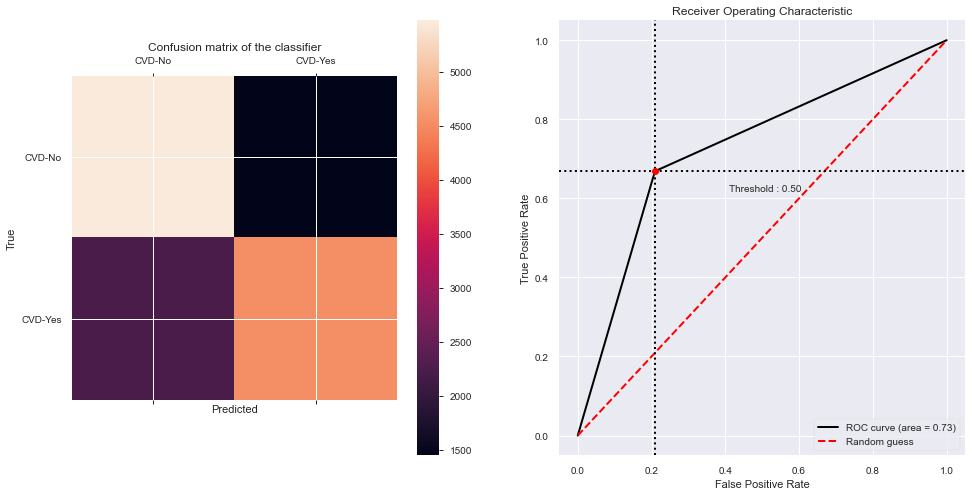

In [8]:
# display model metrics
displayModel_metrics(LR_CV, X_test, Y_test, Y_predict_CV)

The model when run with default parameters predicted a cardiovascular disease diagnosis with 73% accuracy. The sensitivity (true positive rate) of 79% is currently higher than the specificity (true negative rate) 67% which we would consider to be a good outcome in our likely scenario described in Lab 1 of favoring a bias toward positive diagnosis. The ROC curve shows the relationship between the model's ability to correctly vs incorrectly classify a patient as positive. We could potentially make adjustments that could shift the ROC curve to have a higher true positive rate at the expense of increasing the false positive rate.

### Logistic Regression with Normalization

The next step to attempt to improve the accuracy of the model is to normalize the data by scaling all of the values to be between zero and 1. 

In [9]:
# normalize the data by feature scaling 0 - 1
from sklearn.preprocessing import StandardScaler

scaled_X_train = StandardScaler().fit_transform(X_train)
scaled_X_test = StandardScaler().fit_transform(X_test)

In [10]:
%%time
# Fit the Model
LR_CV.fit(scaled_X_train, Y_train)

# Predicted Values 
Y_predict_CV=LR_CV.predict(scaled_X_test) 

Wall time: 4.02 s


Confusion Matrix:
[[5480 1445]
 [2248 4532]]
Accuracy       : 73.05
Sensitivity    : 79.13
Specificity    : 66.84

             Classification report :         
               precision    recall  f1-score   support

           1       0.76      0.67      0.71      6780
           0       0.71      0.79      0.75      6925

    accuracy                           0.73     13705
   macro avg       0.73      0.73      0.73     13705
weighted avg       0.73      0.73      0.73     13705



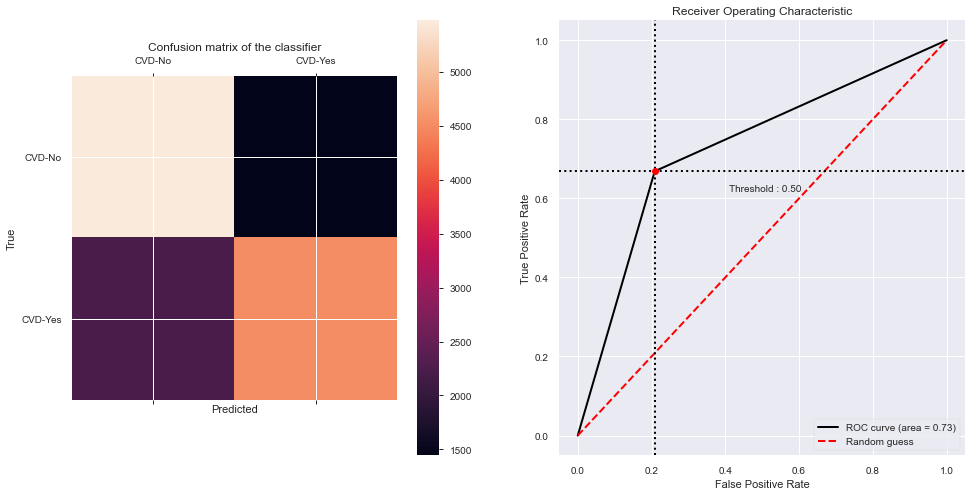

In [11]:
# Display model metric
displayModel_metrics(LR_CV, scaled_X_test, Y_test, Y_predict_CV)

With default parameter values for logistic regression model with or without normalization, we obtained test dataset accuracy of  73%. The confusion matrix suggests that false positive rate is higher than false negative rate which indicate model is failing to detect patients with CVD than patients without CVD.

### Hyper parameter tuning - Logistic Regression 

We wish to have the most accurate model we can develop. Finer tuning increases the problem of over fitting data which we will test after. 

In [12]:
# this shows us logistic regression parameters
LR_CV.get_params().keys()

dict_keys(['Cs', 'class_weight', 'cv', 'dual', 'fit_intercept', 'intercept_scaling', 'l1_ratios', 'max_iter', 'multi_class', 'n_jobs', 'penalty', 'random_state', 'refit', 'scoring', 'solver', 'tol', 'verbose'])

The code below performs a grid search of the best values of the specified parameters. We will try to optimize a combination of the parameters *penalty*, *C* (inverse regularization strength), *class_weight*, and *solver* algorithm.

In [13]:
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

LR = LogisticRegression()

# define models and parameters
penalty_LR = ['l1', 'l2', 'elasticnet', 'none'] 
C_LR = [0.001, 0.01, 0.1, 1, 10, 100]  
max_iter_LR = [500,1000, 1500]
class_weight_LR = ['balanced','none']
solver_LR = ['lbfgs', 'liblinear']
#solver_LR = ['liblinear']
# define grid search
grid = dict(penalty=penalty_LR, C=C_LR, max_iter=max_iter_LR, class_weight=class_weight_LR, solver=solver_LR)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
grid_search = GridSearchCV(estimator=LR, param_grid=grid, n_jobs=-1, cv=cv, scoring='accuracy',error_score=0)

In [14]:
%%time
grid_result1 = grid_search.fit(scaled_X_train, Y_train)
# summarize results
print("Best: %f using %s" % (grid_result1.best_score_, grid_result1.best_params_))
means = grid_result1.cv_results_['mean_test_score']
stds = grid_result1.cv_results_['std_test_score']
params = grid_result1.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.728015 using {'C': 0.01, 'class_weight': 'balanced', 'max_iter': 500, 'penalty': 'l1', 'solver': 'liblinear'}
0.000000 (0.000000) with: {'C': 0.001, 'class_weight': 'balanced', 'max_iter': 500, 'penalty': 'l1', 'solver': 'lbfgs'}
0.723996 (0.005478) with: {'C': 0.001, 'class_weight': 'balanced', 'max_iter': 500, 'penalty': 'l1', 'solver': 'liblinear'}
0.727480 (0.004758) with: {'C': 0.001, 'class_weight': 'balanced', 'max_iter': 500, 'penalty': 'l2', 'solver': 'lbfgs'}
0.727468 (0.004771) with: {'C': 0.001, 'class_weight': 'balanced', 'max_iter': 500, 'penalty': 'l2', 'solver': 'liblinear'}
0.000000 (0.000000) with: {'C': 0.001, 'class_weight': 'balanced', 'max_iter': 500, 'penalty': 'elasticnet', 'solver': 'lbfgs'}
0.000000 (0.000000) with: {'C': 0.001, 'class_weight': 'balanced', 'max_iter': 500, 'penalty': 'elasticnet', 'solver': 'liblinear'}
0.727571 (0.004631) with: {'C': 0.001, 'class_weight': 'balanced', 'max_iter': 500, 'penalty': 'none', 'solver': 'lbfgs'}
0.000000 (0.

In [15]:
Y_predict_gs = grid_result1.predict(scaled_X_test)
Coef_weights = grid_result1.best_estimator_.coef_.ravel()

# Accuracy
print('Best Accuracy with Grid Search : {:.3f}'.format(grid_result1.best_score_))

matrix = classification_report(Y_test, Y_predict_gs,labels=[1,0])

print('\nClassification report : \n',matrix)

Best Accuracy with Grid Search : 0.728

Classification report : 
               precision    recall  f1-score   support

           1       0.76      0.67      0.71      6780
           0       0.71      0.79      0.75      6925

    accuracy                           0.73     13705
   macro avg       0.73      0.73      0.73     13705
weighted avg       0.73      0.73      0.73     13705



After optimizing these parameter values, the accuracy remains about the same as the defaults at approx 73%.

#### Learning Curve

We wish to check the impact of training set size against accuracy. There should be a threshold where increasing the amount of data is no longer useful.

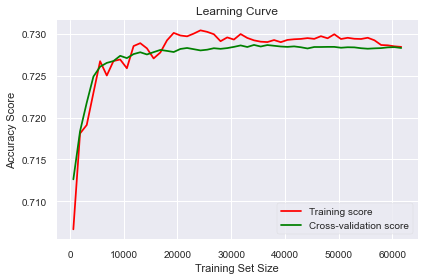

Wall time: 18 s


In [17]:
%%time
### Learning Curve 

from sklearn.model_selection import learning_curve

scaled_X = StandardScaler().fit_transform(X)

# Create CV training and test scores for various training set sizes
train_sizes, train_scores, test_scores = learning_curve(grid_search.best_estimator_, 
                                                        scaled_X, 
                                                        y,
                                                        # Number of folds in cross-validation
                                                        cv=10,
                                                        # Evaluation metric
                                                        scoring='accuracy',
                                                        # Use all computer cores
                                                        n_jobs=-1, 
                                                        # 50 different sizes of the training set
                                                        train_sizes=np.linspace(0.01, 1.0, 50))

# Create means and standard deviations of training set scores
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)

# Create means and standard deviations of test set scores
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Draw lines
plt.plot(train_sizes, train_mean, color="r",  label="Training score")
plt.plot(train_sizes, test_mean, color="g", label="Cross-validation score")

# Create plot
plt.title("Learning Curve")
plt.xlabel("Training Set Size"), plt.ylabel("Accuracy Score"), plt.legend(loc="best")
plt.tight_layout()
plt.show()

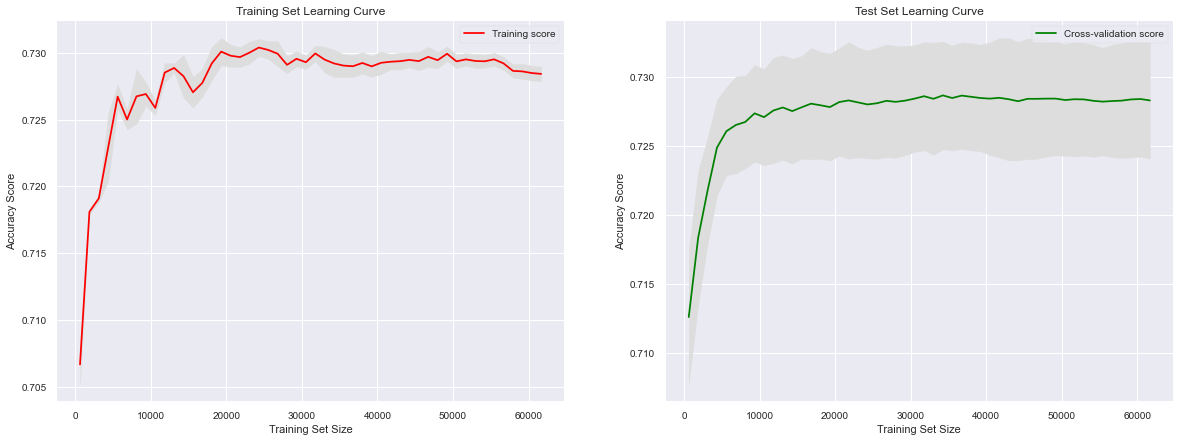

In [18]:
# Draw bands
plt.rcParams['figure.figsize'] = (20, 7)
plt.subplot(1,2,1)
plt.plot(train_sizes, train_mean, color="r",  label="Training score")
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color="#DDDDDD")
plt.title("Training Set Learning Curve")
plt.xlabel("Training Set Size"), plt.ylabel("Accuracy Score"), plt.legend(loc="best")

plt.subplot(1,2,2)
plt.plot(train_sizes, test_mean, color="g", label="Cross-validation score")
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, color="#DDDDDD")
plt.title("Test Set Learning Curve")
plt.xlabel("Training Set Size"), plt.ylabel("Accuracy Score"), plt.legend(loc="best")

plt.show()

A learning curve shows the validation and training score of an estimator for varying numbers of training samples. It is a tool to find out how much we benefit from adding more training data and whether the estimator suffers more from a variance error or a bias error.

For the logistic regression, The training score and the cross-validation score are both not very good. However, the training score is a little low at the beginning and decreases and the cross-validation score is low at the beginning and increases with more training samples. Both the validation score and the training score converge to a value that is  low with increasing size of the training set. Thus, we will probably not benefit much from more training data.

While we are achieving an accuracy level of 73%, the variance in our results suggests our model has a true accuracy of 71-72%

### Support Vector Machine Models

The code below produces a support vector machine model for the data using a polynomial kernel with *kernel='poly'* and other parameters at their defaults.

In [19]:
%%time
# Using default setting of SVM, we ran through the cross validation loop and set the training and testing 
# variable for one single iteration
from sklearn.svm import SVC
from sklearn import metrics as mt
from sklearn.model_selection import ShuffleSplit
cv = ShuffleSplit(n_splits=1, test_size=0.20, random_state=0)
scl_obj = StandardScaler()
svm_clf = SVC(kernel='poly', random_state = 0) # get object (C=0.5, kernel='poly', degree=3, gamma='auto')

for train_indices, test_indices in cv.split(X,y): 
    X_train = X[train_indices]
    Y_train = y[train_indices]
    
    X_test = X[test_indices]
    Y_test = y[test_indices] 
    
    X_train_scaled = scl_obj.fit_transform(X_train) # apply to training and test sets
    X_test_scaled = scl_obj.transform(X_test) 
    
    svm_clf.fit(X_train_scaled, Y_train)  # train object
    y_hat = svm_clf.predict(X_test_scaled) # get test set precitions
   
    #Performance Metrics
    acc = mt.accuracy_score(Y_test,y_hat)
    conf = mt.confusion_matrix(Y_test,y_hat)
    print('accuracy:', acc )
    print(conf)
    sensitivity1 = conf[0,0]/(conf[0,0]+conf[0,1])*100
    print('Sensitivity : ', sensitivity1 )
    specificity1 = conf[1,1]/(conf[1,0]+conf[1,1])
    print('Specificity : ', specificity1)

accuracy: 0.7302444363371032
[[5795 1291]
 [2406 4213]]
Sensitivity :  81.78097657352527
Specificity :  0.6365009820214534
Wall time: 2min 9s


The accuracy of this SVM model is almost identical to the best logistic regression model. We can try to tune the hyperparameters of the SVM code but these results allude to the likely scenario that we shouldnt expect significant improvements to this accuracy. 

The run time for SVM model is much longer than Logistic regression. A single model would execute more than 4 mins with kernel "poly" and with  a grid search, which would take about 300 different models with different combination of parameters, it would take more than 12 hours to execute SVM model. In order to reduce computimg time, we decided to use the stochastic gradient descent (SGD) Classifier on SVM. 

#### SVM classifier with stochastic descent

In [20]:
%%time
from sklearn.model_selection import StratifiedShuffleSplit 

cv = StratifiedShuffleSplit( n_splits=1,test_size=0.2)
from sklearn.linear_model import SGDClassifier
from sklearn import metrics as mt

regularize_const = 0.1
iterations =10
svm_sgd = SGDClassifier(alpha=regularize_const,
        fit_intercept=True, l1_ratio=0.0, learning_rate='optimal',
        loss='hinge', n_iter_no_change=iterations, n_jobs=-1, penalty='l2')

scl = StandardScaler()
for train_idx, test_idx in cv.split(X,y):
    svm_sgd.fit(scl.fit_transform(X[train_idx]),y[train_idx])
    yhat = svm_sgd.predict(scl.transform(X[test_idx]))

    conf = mt.confusion_matrix(y[test_idx],yhat)
    acc = mt.accuracy_score(y[test_idx],yhat)
print('SVM:', acc)
print('Confusion marix: \n', conf)
sensitivity1 = conf[0,0]/(conf[0,0]+conf[0,1])*100
print('Sensitivity : ', sensitivity1 )
specificity1 = conf[1,1]/(conf[1,0]+conf[1,1])
print('Specificity : ', specificity1)

SVM: 0.7224370667639548
Confusion marix: 
 [[5682 1243]
 [2561 4219]]
Sensitivity :  81.78097657352527
Specificity :  0.6222713864306785
Wall time: 180 ms


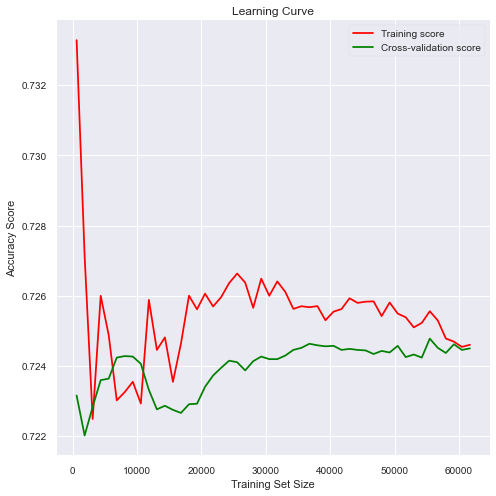

Wall time: 9.64 s


In [21]:
%%time
### Learning Curve 

from sklearn.model_selection import learning_curve
svm_Coef_weights = svm_sgd.coef_.ravel()
plt.rcParams['figure.figsize'] = (7, 7)
# Create CV training and test scores for various training set sizes
train_sizes, train_scores, test_scores = learning_curve(svm_sgd, 
                                                        scaled_X, 
                                                        y,
                                                        # Number of folds in cross-validation
                                                        cv=10,
                                                        # Evaluation metric
                                                        scoring='accuracy',
                                                        # Use all computer cores
                                                        n_jobs=-1, 
                                                        # 50 different sizes of the training set
                                                        train_sizes=np.linspace(0.01, 1.0, 50))

# Create means and standard deviations of training set scores
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)

# Create means and standard deviations of test set scores
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Draw lines
plt.plot(train_sizes, train_mean, color="r",  label="Training score")
plt.plot(train_sizes, test_mean, color="g", label="Cross-validation score")

# Create plot
plt.title("Learning Curve")
plt.xlabel("Training Set Size"), plt.ylabel("Accuracy Score"), plt.legend(loc="best")
plt.tight_layout()
plt.show()

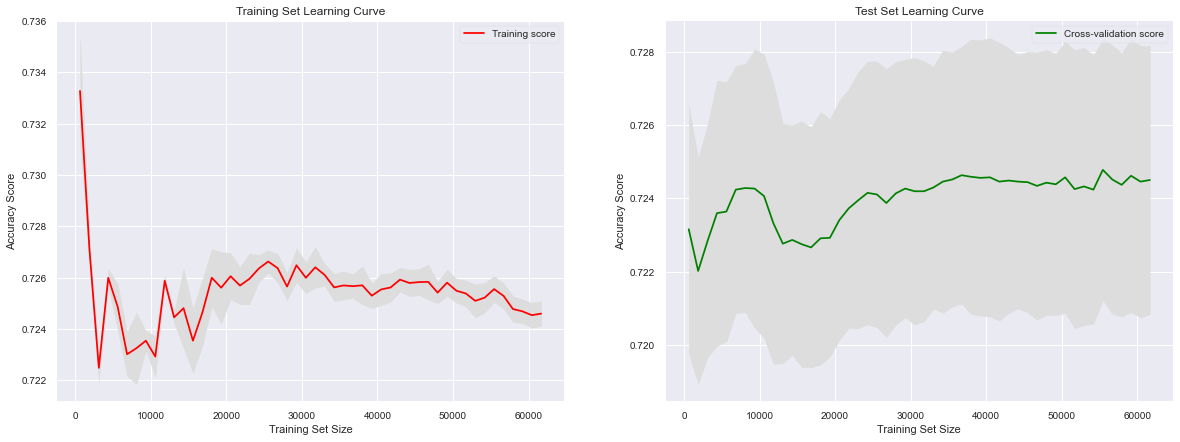

In [22]:
# Draw bands
plt.rcParams['figure.figsize'] = (20, 7)
plt.subplot(1,2,1)
plt.plot(train_sizes, train_mean, color="r",  label="Training score")
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color="#DDDDDD")
plt.title("Training Set Learning Curve")
plt.xlabel("Training Set Size"), plt.ylabel("Accuracy Score"), plt.legend(loc="best")

plt.subplot(1,2,2)
plt.plot(train_sizes, test_mean, color="g", label="Cross-validation score")
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, color="#DDDDDD")
plt.title("Test Set Learning Curve")
plt.xlabel("Training Set Size"), plt.ylabel("Accuracy Score"), plt.legend(loc="best")

plt.show()

Again, we don't see any improvement to our previously achieved 72-73% accuracy. The training/test learning curves are leveling out at around 30,000 records but when closely examining the scale, we see that there really isnt much practical variation in accuracy after about 3000-5000 training records.

## Model Advantages

Based on the accuracy of all of the models with different parameters, there does not appear to be much advantage to using either model type over the other. They both predict a cardiovascular disease diagnosis with about 72-73% accuracy. The SVM models did generally have a higher sensitivity than the logit regression models which could be a favorable condition if we want to err toward favoring a positive diagnosis at the expense of having more false positives.

Building logistic regression model and SVM_SGD models were both fairly quick. However, utilizing a grid search with logistic regression model took around 3 minutes where as SVM was running more than 12 hours. Once hyperparameters are tuned, the SVM requires marginally more time to run than logistic regression.

## Interpret Feature Importance

#### Logistic regression Feature Importance

We can view the most important features in the logisitic regression analysis by viewing the coefficents for the weights of each variable in predicting *cardio*. Feature importance below was performed for the model created using the model with hyperparameters tuned by the grid search.

In [24]:
# Important features with their weights 
features = df_onehot.columns

imp_feature_df = pd.DataFrame({'feature_names':df_onehot.columns, 'Coef_weights':Coef_weights})
imp_feature_df.sort_values(by='Coef_weights', inplace=True, ascending=False )

imp_feature_df

,feature_names,Coef_weights
2,ap_hi,0.925636
7,age_years,0.336327
11,cholesterol_3,0.328484
1,weight,0.141512
10,cholesterol_2,0.111802
3,ap_lo,0.097504
12,gluc_2,0.006509
9,is_male,0.004608
8,BMI,0.000000
0,height,-0.016786


Text(0, 0.5, 'Feature Names')

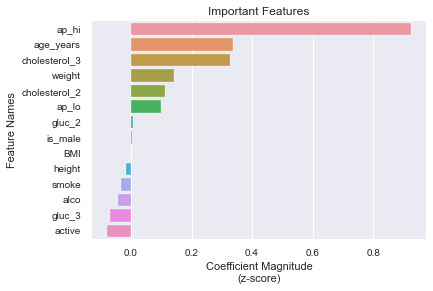

In [25]:
# Visulization of important features 
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

ax = sns.barplot(x ='Coef_weights', y = 'feature_names',data=imp_feature_df, orient= 'h')
ax.set_title("Important Features")
ax.set_xlabel("Coefficient Magnitude\n(z-score)")
ax.set_ylabel("Feature Names")

- *ap_hi* (systolic blood pressure), *age_years*, *cholesterol*, *weight* and *ap_lo* (low blood pressure) are the top five positive influential factors. The high positive influence of systolic blood pressure on positive diagnosis is consistent with what we found in visualizing this data in Lab 1, and the weight of nearly .9 demonstrates that this is by far the most important variable in the prediction. All of the variables that appeared as positive influences on a positive diagnosis are amoung the common contributors to heart disease outlined by the American Heart Association, so we don't see anything unexpected here.


- The effects of attributes that contribute to a negative diagnosis all have much smaller weights than the top attributes influencing a positive diagnosis. *Active* is the most influential variable with a negative effect on *cardio*, but the coefficient isn't even 10% of that for the positive effect of *ap_hi*. This result is also intuitive based on our prior analysis in Lab 1. Interestingly, a "very high" level of glucose actually had a negative effect on *cardio*, indicating that very high glucose levels actually decrease (although with small effect) the chance of a positive heart disease diagnosis per this model. This actually supports the decision to one-hot encode the attribute into categorical variables rather than leave it as ordinal, as there is a very slight positive effect (but practically almost no influence) on the model for a "high" level of glucose. 

#### Examining Feature Importance with Recursive Feature Elimination 

In [28]:
# recursive Feature elimination to identify important features
from sklearn.feature_selection import RFECV

# Instance of Recursive Feature Elimination
rfecv = RFECV(estimator=grid_search.best_estimator_, step=1, cv=cv, n_jobs=8, scoring='accuracy')

# Fit RFE
rfecv.fit(scaled_X, y)

RFECV(cv=StratifiedShuffleSplit(n_splits=1, random_state=None, test_size=0.2,
            train_size=None),
      estimator=LogisticRegression(C=0.01, class_weight='balanced', dual=False,
                                   fit_intercept=True, intercept_scaling=1,
                                   l1_ratio=None, max_iter=500,
                                   multi_class='auto', n_jobs=None,
                                   penalty='l1', random_state=None,
                                   solver='liblinear', tol=0.0001, verbose=0,
                                   warm_start=False),
      min_features_to_select=1, n_jobs=8, scoring='accuracy', step=1,
      verbose=0)

In [29]:
# get column names
columns = pd.DataFrame(list(df_onehot.columns))

# Get the ranking of features
ranking = pd.DataFrame(rfecv.ranking_)

# ranking and their importance
rfe_selected = pd.DataFrame()
rfe_selected  = pd.concat([columns, ranking], axis=1)
rfe_selected.columns = ['Feature Name', 'Ranking']
rfe_selected_sorted = rfe_selected.sort_values(by=['Ranking'], ascending=True)
print(rfe_selected_sorted)

     Feature Name  Ranking
1          weight        1
2           ap_hi        1
3           ap_lo        1
5            alco        1
6          active        1
7       age_years        1
10  cholesterol_2        1
11  cholesterol_3        1
13         gluc_3        1
4           smoke        2
0          height        3
9         is_male        4
12         gluc_2        5
8             BMI        6


Using recursive feature elimination resulted in the interesting change of weight being at the top of list of important features whereas before it was #3.

#### SVM Feature Importance 

We can use a similar feature importance table and histogram for SVM as the logistic regression model for the *linear* SVM model. This is not a viable way to look at feature importance for SVM models that do not use linear vectors.

In [31]:
# Important features with their weights 
features = df_onehot.columns
svm_Coef_weights = svm_sgd.coef_.ravel()

imp_feature_df = pd.DataFrame({'feature_names':df_onehot.columns, 'Coef_weights':svm_Coef_weights})
imp_feature_df.sort_values(by='Coef_weights', inplace=True, ascending=False )

imp_feature_df

,feature_names,Coef_weights
2,ap_hi,0.638041
11,cholesterol_3,0.283714
7,age_years,0.243124
3,ap_lo,0.214140
10,cholesterol_2,0.122990
1,weight,0.113831
8,BMI,0.057688
12,gluc_2,0.013423
9,is_male,0.008462
13,gluc_3,0.001398


Text(0, 0.5, 'Feature Names')

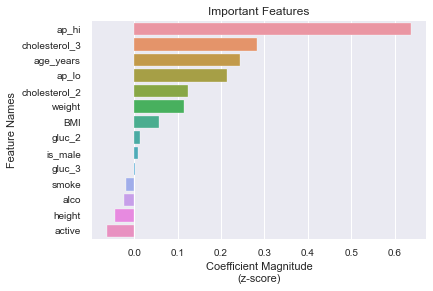

In [32]:
# Visulization of important features 
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

ax = sns.barplot(x ='Coef_weights', y = 'feature_names',data=imp_feature_df, orient= 'h')
ax.set_title("Important Features")
ax.set_xlabel("Coefficient Magnitude\n(z-score)")
ax.set_ylabel("Feature Names")

The feature importances appear very similar in the SVM model to the logistic regression model, but is less dependent on the *ap_hi* attribute, despite it still being by far the most important. Some of the other important features shifted around but generally had similar attribute effects.

 ## Interpret Support Vectors

We can use plots of points chosen for support vectors in the SVM models to visualize and analyze the chosen support vectors. The plots below are for the SVM model using the default settings with *kernel='poly'*. 

In [33]:
# look at the support vectors
print(svm_clf.support_vectors_.shape)
print(svm_clf.n_support_)

(36013, 14)
[17974 18039]


SVM model selected 36013 observations from the training set as support vectors to maximize the margin.

In [34]:
# make a dataframe of the training data
df_tested_on = df_onehot.iloc[train_indices] # saved from above, the indices chosen for training
# now get the support vectors from the trained model
df_support = df_tested_on.iloc[svm_clf.support_,:]

df_support['cardio'] = y[svm_clf.support_] # add back in the 'cardio' Column to the pandas dataframe
df_support.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 36013 entries, 9068 to 42613
Data columns (total 15 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   height         36013 non-null  int64  
 1   weight         36013 non-null  float64
 2   ap_hi          36013 non-null  int64  
 3   ap_lo          36013 non-null  int64  
 4   smoke          36013 non-null  int64  
 5   alco           36013 non-null  int64  
 6   active         36013 non-null  int64  
 7   age_years      36013 non-null  int64  
 8   BMI            36013 non-null  float64
 9   is_male        36013 non-null  int32  
 10  cholesterol_2  36013 non-null  uint8  
 11  cholesterol_3  36013 non-null  uint8  
 12  gluc_2         36013 non-null  uint8  
 13  gluc_3         36013 non-null  uint8  
 14  cardio         36013 non-null  int64  
dtypes: float64(2), int32(1), int64(8), uint8(4)
memory usage: 3.3 MB


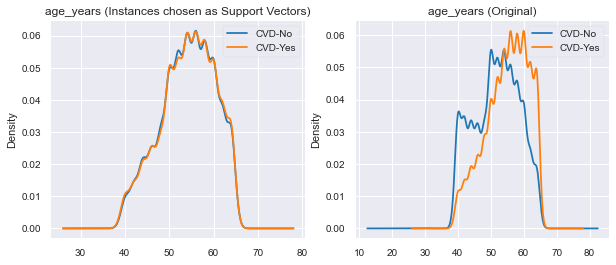

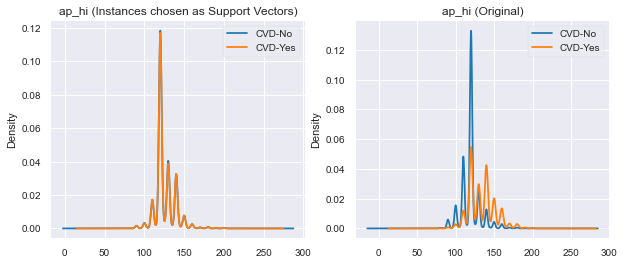

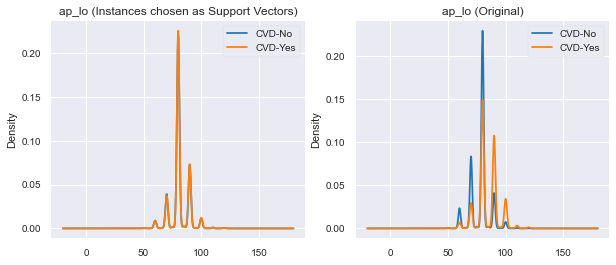

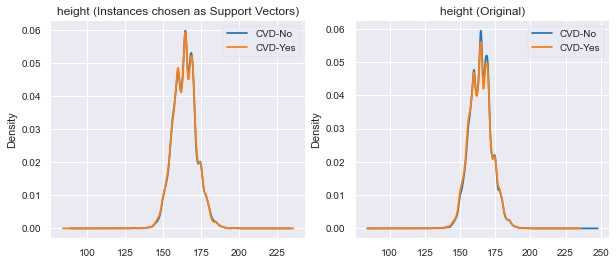

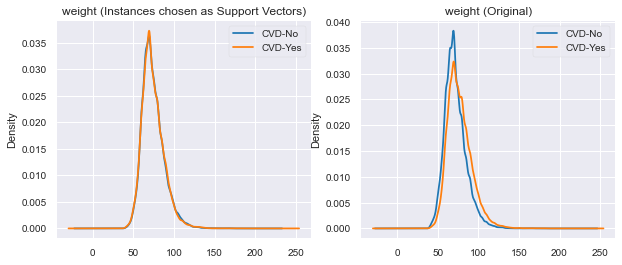

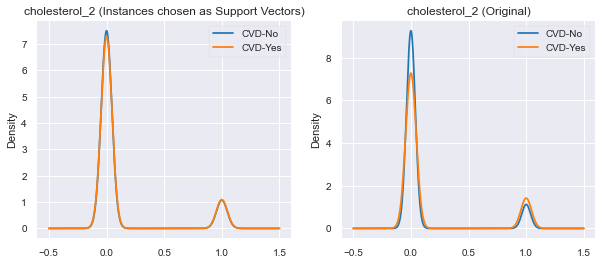

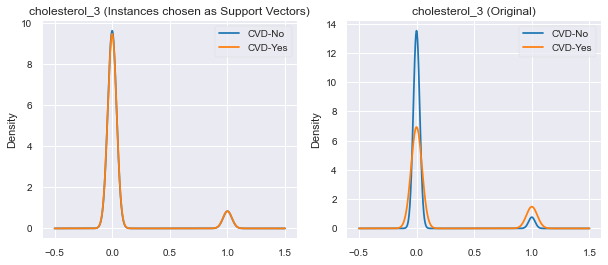

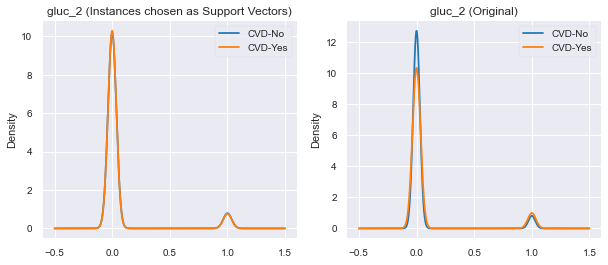

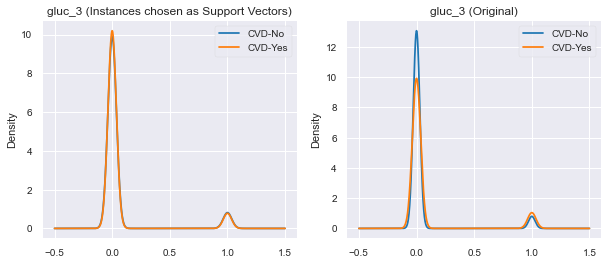

In [35]:
# now lets see the statistics of these attributes
from pandas.plotting import boxplot

# group the original data and the support vectors
df_grouped_support = df_support.groupby(['cardio'])
df_grouped = df_1.groupby(['cardio'])

# plot KDE of Different variables
vars_to_plot =  ['age_years','ap_hi','ap_lo','height','weight','cholesterol_2', 'cholesterol_3', 'gluc_2', 'gluc_3']

for v in vars_to_plot:
    plt.figure(figsize=(10,4))
    # plot support vector stats
    plt.subplot(1,2,1)
    ax = df_grouped_support[v].plot.kde() 
    plt.legend(['CVD-No','CVD-Yes'])
    plt.title(v+' (Instances chosen as Support Vectors)')
    
    # plot original distributions
    plt.subplot(1,2,2)
    ax = df_grouped[v].plot.kde() 
    plt.legend(['CVD-No','CVD-Yes'])
    plt.title(v+' (Original)')


The original plots (on the right) just show us what we saw in our Lab 1 visualizations, which are the original separations between diagnoses for each variable. With the high number of observations in this dataset, we are unsurprised by the plots of the chosen support vectors that show separation in distributions that are not distinct like the separation for the original data. This is because the support vectors tend to be instances on the edge of the class boundaries and also instances that are classified incorrectly in the training data.

#### **References**

- https://chrisalbon.com/machine_learning/model_evaluation/plot_the_learning_curve/


- https://github.com/jakemdrew/DataMiningNotebooks/blob/master/04.%20Logits%20and%20SVM.ipynb

